#Approach1 : MAP-REDUCE

##Map Phase → "Summarize each chunk"
You split the document into smaller parts (chunks). For each chunk, the LLM generates a local summary.These summaries are independent of each other — there's no global context yet.


##Reduce Phase → "Summarize the summaries"
You gather all the chunk summaries and pass them to the LLM again.The LLM then generates a combined summary — possibly in your desired format (bullet points, abstract, etc.).

In [ ]:
!pip install -q langchain-community langchain-core langchain google-generativeai PyMuPDF


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
pip install langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI

# ✅ Safer: Set your API key as an environment variable
os.environ["GOOGLE_API_KEY"] = "your_api_key"

# ✅ Now initialize the LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0.3)

1. ChatGoogleGenerativeAI: This is a class from langchain_google_genai that wraps Google’s Gemini API (Generative AI for chat).

2. model="gemini-2.0-flash": Specifies the exact variant of Gemini to use — "Flash" is optimized for speed and cost-efficiency, while still being capable.

3. temperature=0.3: Controls randomness in output.

- Lower (e.g., 0.3) = more focused, deterministic, and repetitive

- Higher (e.g., 0.9) = more creative, diverse, but potentially off-topic

#APPROACH 2: CLUSTERING

In [ ]:
!pip install -q pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.5/305.5 kB 3.5 MB/s eta 0:00:00


##Next Steps
1. Importing PDF Loaders
2. Load the PDF Document
3. Read All Pages into Memory
4. Trim the Beginning and End Pages
5. Concatenate the Page Contents

In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain_community.document_loaders import PyMuPDFLoader


# Load the book if its short
#loader = PyPDFLoader("/content/orwellanimalfarm.pdf")

#if the book is long
loader = PyMuPDFLoader("/content/the-fountainhead.pdf")

pages = loader.load()

# Cut out the open and closing parts
pages = pages[3:]

# Combine the pages, and replace the tabs with spaces
text = ""

for page in pages:
    text += page.page_content

text = text.replace('\t', ' ')

llm.get_num_tokens(...) is a utility method provided by LangChain’s ChatGoogleGenerativeAI wrapper. It estimates how many tokens the given input (text) would use based on the tokenizer of the underlying LLM (here, Gemini 2.0 Flash). This is useful for checking whether the input fits within the model’s context window (i.e., max token limit).

In [ ]:
num_tokens = llm.get_num_tokens(text)

print (f"This book has {num_tokens} tokens in it")

This book has 450317 tokens in it


In [ ]:
# LangChain Core
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Gemini LLM + Embeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Vector Store (FAISS)
from langchain.vectorstores import FAISS

# Summarization Chain
from langchain.chains.summarize import load_summarize_chain

# Clustering
import numpy as np
from sklearn.cluster import KMeans

###Next we apply a splitter to the book text (wrapped in a list because it expects a list of documents). This returns a list of Document objects — each one containing a chunk of the book.

1. RecursiveCharacterTextSplitter: A LangChain utility that recursively splits text by the given separators, prioritizing larger ones (\n\n) first, then falling back to smaller ones (\n, \t) if needed.

2. chunk_size=10000: Each chunk will try to be close to 10,000 characters (not tokens).

3. chunk_overlap=3000: Each new chunk will overlap 3,000 characters with the previous one. This ensures that important context isn’t lost between chunks (great for LLMs that work one chunk at a time).



In [ ]:
text_splitter = RecursiveCharacterTextSplitter(separators=["\n\n", "\n", "\t"], chunk_size=10000, chunk_overlap=3000)

docs = text_splitter.create_documents([text])
num_documents = len(docs)

print (f"Now our book is split up into {num_documents} documents")

Now our book is split up into 251 documents


Next we use Google Gemini’s embedding model to convert our chunked book content (docs) into vector embeddings — numerical representations that capture the meaning of the text.

In [ ]:
# Instantiate Gemini embedding model
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# Embed your documents (list of strings)
vectors = embeddings.embed_documents([x.page_content for x in docs])


This code performs K-Means clustering on your Gemini embeddings to find natural groupings among the document chunks — and uses the elbow method to determine the ideal number of clusters (k).

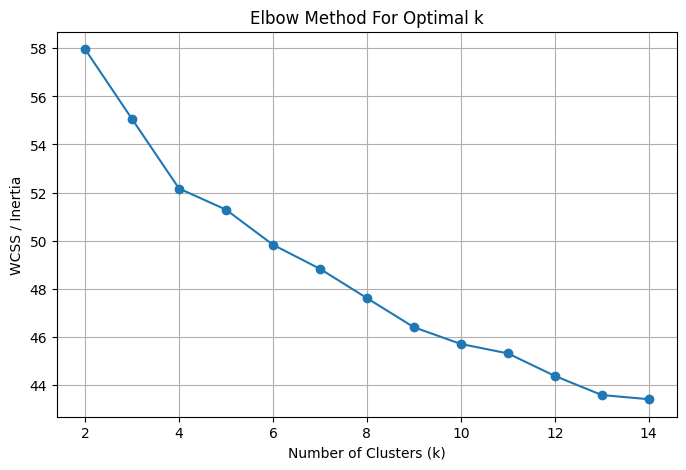

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Assuming `vectors` is a list or np.array of embeddings from Gemini
X = np.array(vectors)

# Range of k values to test
k_range = range(2, 15)  # Try between 2 and 20 clusters

inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)  # Sum of squared distances (WCSS)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS / Inertia")
plt.title("Elbow Method For Optimal k")
plt.grid(True)
plt.show()


In [ ]:
# Assuming 'embeddings' is a list or array of 1536-dimensional embeddings

# Choose the number of clusters, this can be adjusted based on the book's content.
# Usually if you have 10 passages from a book you can tell what it's about
num_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

We're using t-SNE (t-distributed Stochastic Neighbor Embedding) to reduce the 1536-dimensional Gemini embeddings into 2D, so we can meaningfully plot and interpret clusters of similar passages.

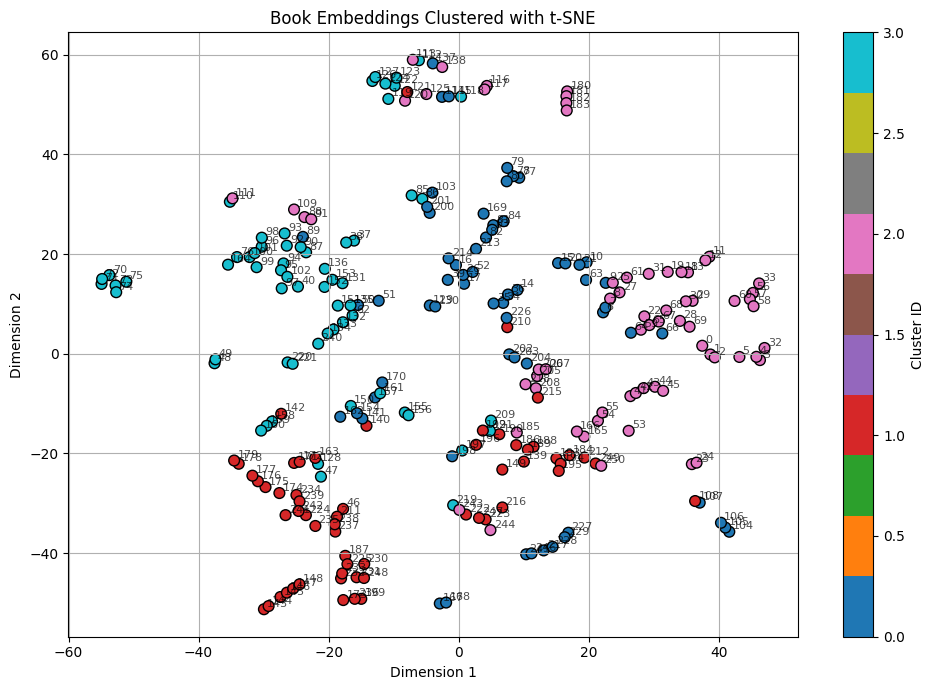

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Create the plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    reduced_data_tsne[:, 0],
    reduced_data_tsne[:, 1],
    c=kmeans.labels_,
    cmap='tab10',  # Use distinct colors for each cluster
    s=60,
    edgecolors='k'
)

# Add text labels (chunk index)
for i, (x, y) in enumerate(reduced_data_tsne):
    plt.text(x + 0.5, y + 0.5, str(i), fontsize=8, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Book Embeddings Clustered with t-SNE')
plt.grid(True)
plt.colorbar(scatter, label='Cluster ID')
plt.tight_layout()
plt.show()


In [ ]:
# Find the closest embeddings to the centroids

# Create an empty list that will hold your closest points
closest_indices = []

# Loop through the number of clusters you have
for i in range(num_clusters):

    # Get the list of distances from that particular cluster center
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # Find the list position of the closest one (using argmin to find the smallest distance)
    closest_index = np.argmin(distances)

    # Append that position to your closest indices list
    closest_indices.append(closest_index)

After the loop, closest_indices holds the indices of the most representative passage in each of the num_clusters groups

In [ ]:
for idx in closest_indices:
    print(f"Cluster {kmeans.labels_[idx]} representative:\n")
    print(docs[idx].page_content[:500])  # Show first 500 chars
    print("\n" + "-"*80 + "\n")

Cluster 0 representative:

there had been art and skill and its own kind of illogical energy in the career of Guy Francon, 
even if the art consisted only of his social charm and the energy was directed at snaring 
bewildered millionaires. There had been a twisted sort of sense in people's response to Guy 
Francon.He could see no hint of rationality in the things to which people responded now. The leader of 
the profession--on a mean scale, there was no grand scale left in anything--was Gordon L. 
Prescott, Chairman of th

--------------------------------------------------------------------------------

Cluster 1 representative:

dream of every man: the chance and intensity of youth, to be used with the wisdom of 
experience. A new beginning and a climax, together. I have waited and lived, he thought, for 
this.
His twenty-two newspapers, his magazines, his newsreels were given the order: Defend 
Roark. Sell Roark to the public. Stem the lynching."Whatever the facts," Wynand explained 

In [ ]:
selected_indices = sorted(closest_indices)
selected_indices

[np.int64(28), np.int64(95), np.int64(201), np.int64(224)]

- closest_indices might be in cluster order (e.g., [4, 2, 9, 1, 6])

- sorted(...) rearranges it in document order (e.g., [1, 2, 4, 6, 9])

This is useful coz we want to read the representative passages in order of appearance in the book (instead of cluster ID) and we’re about to summarize or display them with natural narrative flow.

###Next, we instruct the LLM to take these most representative chunks one by one, and produce a detailed summary of each chunk

- Step 1: build the prompt

In [ ]:
from langchain.prompts import PromptTemplate
map_prompt = """
You will be given a single passage of a book. This section will be enclosed in triple backticks (```)
Your goal is to give a summary of this section so that a reader will have a full understanding of what happened.
Your response should be at least three paragraphs and fully encompass what was said in the passage.

```{text}```
FULL SUMMARY:
"""
map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

Gemini reads one chunk of raw book text and processes it with self-attention (transformer-based reasoning). Understands structure, characters, events, etc. Generates a 3+ paragraph coherent summary — all from the input chunk

In [ ]:
selected_docs = [docs[doc] for doc in selected_indices]

- Step 2 : run a map-style summarization loop using Gemini, generating detailed summaries for your selected document chunks — one for each cluster’s most representative passage.

Map-style summarization is a part of map-reduce summarization,
inspired by the MapReduce programming model

In [ ]:
# Make an empty list to hold your summaries
summary_list = []

# Load the summarization chain

# "stuff" means: take the document chunk and stuff it directly into the prompt (as long as it's small enough)
# The map_chain here is responsible for summarizing one chunk at a time using our custom prompt.

from langchain.chains.summarize import load_summarize_chain
map_chain = load_summarize_chain(llm, chain_type="stuff", prompt=map_prompt_template)

# Loop through a range of the lenght of your selected docs
for i, doc in enumerate(selected_docs):

    # Go get a summary of the chunk
    chunk_summary = map_chain.run([doc])

    # Append that summary to your list
    summary_list.append(chunk_summary)

    print (f"Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:250]} \n")

Summary #0 (chunk #28) - Preview: Peter Keating visits Howard Roark, offering him a job at Francon & Heyer. Roark accepts, but only on the condition that he does no design work, specifically no "Louis XV skyscrapers," and is instead placed in the engineering department for inspection 

Summary #1 (chunk #95) - Preview: The passage details a complex and destructive relationship between Dominique Francon and Howard Roark. It begins with Joel Sutton seeking Dominique's advice on which architect to hire for a new building. Dominique, despite seemingly admiring Roark's  

Summary #2 (chunk #201) - Preview: Peter Keating finds himself increasingly alienated and out of step with the changing architectural landscape. He observes that the values and standards he once understood have been replaced by what he perceives as irrational and fraudulent trends. Ar 

Summary #3 (chunk #224) - Preview: Gail Wynand, driven by a desire to wield his power and vindicate his past, orders his media empire to d

Now, we’re combining all the individual chunk summaries (from the map step) into one long string and wrapping it into a single Document.

In [ ]:
summaries = "\n".join(summary_list)

# Convert it back to a document
summaries = Document(page_content=summaries)

print (f"Your total summary has {llm.get_num_tokens(summaries.page_content)} tokens")

Your total summary has 1574 tokens


###After the below code, LangChain will "stuff" all the content from the input Document(s) into a single prompt, and send it to the LLM.

In [ ]:
combine_prompt = """
You will be given a series of summaries from a book. The summaries will be enclosed in triple backticks (```).

Your goal is to produce a brief, coherent summary of the entire book.

Start your summary with a suitable introduction sentence that clearly states what the book is about.
Then, continue to summarize the main events, characters, and themes in a brief but structured way.
The reader should be able to grasp what happened in the book.


```{text}```

VERBOSE SUMMARY:
"""

combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [ ]:
reduce_chain = load_summarize_chain(llm=llm,
                             chain_type="stuff",
                             prompt=combine_prompt_template,
                                    #verbose=True  Set this to true if you want to see the inner workings
                                   )

In [ ]:
output = reduce_chain.run([summaries])
print (output)

"The Fountainhead" by Ayn Rand explores the themes of individualism versus collectivism through the life and career of architect Howard Roark, who refuses to compromise his artistic vision. The story begins with Roark's expulsion from architecture school due to his unconventional designs. He then works for various firms, including Francon & Heyer, where he encounters Peter Keating, a talented but insecure architect who prioritizes popularity over integrity. Keating's ambition leads him to seek Roark's help secretly while publicly undermining him. Roark also meets Dominique Francon, a complex and cynical woman who is drawn to his uncompromising nature but attempts to destroy him to protect herself from the world's mediocrity. Their relationship is marked by intense passion and a destructive dynamic.

As Keating's career declines due to his lack of originality, Roark continues to face challenges, including the rejection of his designs and the struggle to find clients who appreciate his v

What Gemini is doing:

1. Receives multiple summaries (1 per selected chunk) as a long text block

2. Uses its long-context reasoning to:

- Synthesize common themes

- Identify narrative arc

- Preserve chronology and logic

- Generates a final, high-level book summary

#Evaluation of the generated summary

In [ ]:
!pip install -q rouge bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.5 MB/s eta 0:00:00


In [ ]:
reference_summary1 = """Into Thin Air is a harrowing nonfiction account of a catastrophic expedition to Mount Everest, written by
journalist and mountaineer Jon Krakauer. The book chronicles the events of May 1996, when several climbing teams, including
Krakauer’s, were caught in a deadly storm just after reaching the summit. It explores not only the physical dangers of
high-altitude climbing but also the psychological and ethical complexities that arise in extreme environments.

Krakauer joined the expedition as part of a journalistic assignment for Outside magazine, intending to report on the increasing
commercialization of Everest. He climbed with Rob Hall’s Adventure Consultants team, while another prominent team was led by
Scott Fischer of Mountain Madness. As the groups ascended the mountain, a series of poor decisions, delays, and deteriorating
weather created a chain of events that spiraled out of control. On May 10th, despite the understanding that climbers should turn
back by a certain time to avoid nightfall, several clients were still ascending past the agreed deadline. This delay proved fatal
when a sudden blizzard struck during their descent.

Caught in the storm, climbers lost visibility and direction. Communication broke down, oxygen supplies dwindled, and exhaustion
took over. Guides like Hall and Fischer, both experienced and admired, were unable to save themselves or their clients.
Some climbers died alone, while others succumbed after heroic attempts to descend. Beck Weathers, presumed dead after being left
overnight in the storm, miraculously regained consciousness and staggered back to camp, though he suffered severe frostbite.

Krakauer survived, but the experience left him traumatized and consumed by guilt, especially over decisions he made in the chaos.
He reflects on the tragedy with a mixture of anger, sorrow, and introspection. The book also scrutinizes the broader issue of
Everest tourism—the practice of guiding relatively inexperienced climbers to the summit for a fee, sometimes at the cost of safety
and judgment.

At its heart, Into Thin Air is not just a chronicle of a disastrous climb but a meditation on ambition, mortality, and the limits
of human endurance. It questions what drives people to risk everything for a fleeting moment at the top of the world, and what
happens when nature proves itself more powerful than preparation or desire."""

reference_summary2 = """Krakauer describes the events leading up to his eventual decision to participate in an Everest expedition in May 1996, despite having mostly given up mountain climbing years before. Krakauer was a journalist for the adventure magazine Outside, and initially his intention to climb Everest had been purely professional. He had planned to climb only as far as the mountain's base camp, and to report on the commercialization of the mountain. However, the idea of going to Everest reawakened his childhood desire to climb the mountain. Krakauer asked his editor to put off publishing the story for a year so that he could train for a climb to the summit.

From there, the book moves between describing events that took place on the mountain, and the unfolding tragedy, which occurs during the push to the summit. The 1996 disaster saw eight recorded deaths, including that of Krakauer's guide, Rob Hall. This is currently the third-highest recorded number of deaths on the mountain in a single day, with the 2015 Mount Everest avalanches causing the most at over 20. Krakauer concludes that essential safety methods that had been adopted over the years by experienced guides on Everest were sometimes compromised by the competition between rival guiding agencies to get their respective clients to the summit."""

generated_summary = """ *Into Thin Air* by Jon Krakauer is a gripping account of the tragic 1996 Mount Everest disaster, exploring
the allure and perils of high-altitude mountaineering, the commercialization of Everest, and the profound ethical dilemmas faced by
climbers in extreme circumstances.

The book begins by providing historical context, detailing early attempts to summit Everest and highlighting the achievements of
pioneers like Edmund Hillary and Tenzing Norgay. It then introduces Rob Hall, a seasoned guide who established Adventure Consultants,
a company that catered to amateur climbers seeking to conquer the world's highest peak. Hall's success, however, drew criticism
from figures like Hillary, who lamented the commercialization of Everest and the influx of inexperienced climbers.

The narrative then focuses on the 1996 Adventure Consultants expedition, introducing a diverse group of clients, including the
author, Jon Krakauer, and the socialite Sandy Hill Pittman. The expedition's journey to Base Camp is described in detail,
highlighting the physical hardships, the stunning yet unforgiving environment, and the presence of rival expeditions,
including Scott Fischer's Mountain Madness team.

As the climbers acclimatize and prepare for their summit attempt, the book delves into the complex dynamics between the various
teams, the Sherpas, and the challenges of managing a large group of climbers at high altitude. The narrative also introduces the
medical crisis of Ngawang Topche, a Sherpa who develops High Altitude Pulmonary Edema (HAPE), underscoring the ever-present threat
of altitude-related illnesses.

The heart of the book recounts the ill-fated summit attempt on May 10, 1996. Despite favorable weather conditions initially, a
series of miscalculations, delays, and the sheer number of climbers on the mountain contribute to a catastrophic situation. As the
climbers ascend, the weather deteriorates rapidly, trapping many near the summit in a blinding blizzard.

The descent becomes a desperate struggle for survival, with climbers becoming disoriented, running out of oxygen, and succumbing to
 exhaustion and hypothermia. The book vividly portrays the chaos and confusion on the South Col, where climbers huddle together for
 warmth, battling the elements and their own failing bodies.

Amidst the chaos, acts of heroism and selflessness are juxtaposed with difficult decisions and ethical compromises.
Anatoli Boukreev, a guide with Mountain Madness, makes several courageous rescue attempts, while other climbers are forced
to make agonizing choices about who to save and who to leave behind. The book also explores the controversial decision of a
Japanese team to continue their ascent without assisting three struggling Ladakhi climbers, who later died.

The book culminates in the tragic deaths of Rob Hall, Doug Hansen, Andy Harris, Yasuko Namba, and Scott Fischer, among others.
Krakauer recounts the desperate attempts to rescue Hall, who is stranded near the summit, and the confusion surrounding the fate
of Harris. The book also details the miraculous survival of Beck Weathers, who is left for dead but manages to find his way back to
camp.

In the aftermath of the disaster, Krakauer grapples with survivor's guilt and attempts to reconstruct the events of that fateful
day, seeking to understand what went wrong and to honor the memory of those who perished. *Into Thin Air* is a powerful and
cautionary tale about the allure of Everest, the dangers of commercialization, and the profound ethical challenges faced by
climbers in the death zone."""



In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional but recommended for full WordNet support

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score

def evaluate_summary(generated_summary, reference_summary):
    print("\n🔍 Preview of Generated Summary:\n", generated_summary[:300], "...\n")
    print("📘 Preview of Reference Summary:\n", reference_summary[:300], "...\n")

    # Smoothing for BLEU to avoid zero scores
    smoothie = SmoothingFunction().method4

    # ROUGE
    rouge = Rouge()
    rouge_scores = rouge.get_scores(generated_summary, reference_summary)[0]

    # BLEU
    bleu = sentence_bleu([reference_summary.split()], generated_summary.split(), smoothing_function=smoothie)

    # ✅ FIXED: METEOR expects tokenized input
    meteor = meteor_score([reference_summary.split()], generated_summary.split())

    # BERTScore
    P, R, F1 = bert_score([generated_summary], [reference_summary], lang="en", rescale_with_baseline=True)

    print("\n==== 📊 Evaluation Metrics ====")
    print("🔴 ROUGE-1: ", rouge_scores['rouge-1'])
    print("🟠 ROUGE-2: ", rouge_scores['rouge-2'])
    print("🟡 ROUGE-L: ", rouge_scores['rouge-l'])
    print("🔵 BLEU:    ", round(bleu, 4))
    print("🟣 METEOR:  ", round(meteor, 4))
    print("🟢 BERTScore (F1):", round(F1.item(), 4))


In [ ]:
evaluate_summary(generated_summary, reference_summary1)


🔍 Preview of Generated Summary:
 The aftermath of the disastrous day is recounted, highlighting the difficult decisions and grim realities 
faced by the surviving climbers. The narrative describes the deaths or near-death states of key members of the team, including 
Rob Hall, Andy Harris, Doug Hansen, Yasuko Namba, Beck Weathers,  ...

📘 Preview of Reference Summary:
 Krakauer describes the events leading up to his eventual decision to participate in an Everest expedition
in May 1996, despite having mostly given up mountain climbing years before. Krakauer was a journalist for the adventure magazine 
Outside, and initially his intention to climb Everest had been p ...



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



==== 📊 Evaluation Metrics ====
🔴 ROUGE-1:  {'r': 0.1417910447761194, 'p': 0.19, 'f': 0.16239315749872174}
🟠 ROUGE-2:  {'r': 0.025, 'p': 0.037037037037037035, 'f': 0.029850741456895407}
🟡 ROUGE-L:  {'r': 0.13432835820895522, 'p': 0.18, 'f': 0.15384614895171322}
🔵 BLEU:     0.0097
🟣 METEOR:   0.1192
🟢 BERTScore (F1): 0.0074


In [ ]:
evaluate_summary(generated_summary, reference_summary1)
evaluate_summary(generated_summary, reference_summary2)


🔍 Preview of Generated Summary:
  *Into Thin Air* by Jon Krakauer is a gripping account of the tragic 1996 Mount Everest disaster, exploring 
the allure and perils of high-altitude mountaineering, the commercialization of Everest, and the profound ethical dilemmas faced by 
climbers in extreme circumstances.

The book begins by pro ...

📘 Preview of Reference Summary:
 Into Thin Air is a harrowing nonfiction account of a catastrophic expedition to Mount Everest, written by 
journalist and mountaineer Jon Krakauer. The book chronicles the events of May 1996, when several climbing teams, including 
Krakauer’s, were caught in a deadly storm just after reaching the su ...



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



==== 📊 Evaluation Metrics ====
🔴 ROUGE-1:  {'r': 0.2979591836734694, 'p': 0.23624595469255663, 'f': 0.2635379012039125}
🟠 ROUGE-2:  {'r': 0.09915014164305949, 'p': 0.07128309572301425, 'f': 0.08293838375926557}
🟡 ROUGE-L:  {'r': 0.2693877551020408, 'p': 0.21359223300970873, 'f': 0.2382671430811689}
🔵 BLEU:     0.0186
🟣 METEOR:   0.2592
🟢 BERTScore (F1): 0.1816

🔍 Preview of Generated Summary:
  *Into Thin Air* by Jon Krakauer is a gripping account of the tragic 1996 Mount Everest disaster, exploring 
the allure and perils of high-altitude mountaineering, the commercialization of Everest, and the profound ethical dilemmas faced by 
climbers in extreme circumstances.

The book begins by pro ...

📘 Preview of Reference Summary:
 Krakauer describes the events leading up to his eventual decision to participate in an Everest expedition in May 1996, despite having mostly given up mountain climbing years before. Krakauer was a journalist for the adventure magazine Outside, and initially his i

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



==== 📊 Evaluation Metrics ====
🔴 ROUGE-1:  {'r': 0.2537313432835821, 'p': 0.11003236245954692, 'f': 0.15349886711208732}
🟠 ROUGE-2:  {'r': 0.065, 'p': 0.026476578411405296, 'f': 0.03762662396200103}
🟡 ROUGE-L:  {'r': 0.22388059701492538, 'p': 0.0970873786407767, 'f': 0.13544017636716635}
🔵 BLEU:     0.0116
🟣 METEOR:   0.222
🟢 BERTScore (F1): 0.0217


We used a clustering-based strategy to:

- Identify representative thematic chunks from across the book.

- Generate detailed, localized summaries of those clusters.

- Combine them into a verbose summary that zooms in on diverse key scenes.

But metrics like ROUGE, BLEU, METEOR are built to compare against:

- Single-reference summaries that are usually zoomed out, high-level, abstracted and often written for different goals: e.g., Wikipedia emphasizes conciseness, not emotional detail or structure


So the scores aren't telling you “your summary is bad” — they're telling you “your summary is different.”



#LETS DO EMBEDDING EVALUATION THEN

In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Initialize the embedding model
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# Convert summaries into 1536-dim embeddings
generated_vec = embeddings.embed_query(generated_summary)
reference1_vec = embeddings.embed_query(reference_summary1)
reference2_vec = embeddings.embed_query(reference_summary2)


In [ ]:
# Convert to NumPy arrays
gen_array = np.array(generated_vec).reshape(1, -1)
ref1_array = np.array(reference1_vec).reshape(1, -1)
ref2_array = np.array(reference2_vec).reshape(1, -1)


# Cosine similarity
similarity_AI_ref = cosine_similarity(gen_array, ref1_array)[0][0]
similarity_wiki_ref = cosine_similarity(gen_array, ref2_array)[0][0]

print(f"🔗 Semantic Similarity Score with AI generated reference summary: {similarity_AI_ref:.4f}")
print(f"📚 Semantic Similarity Score with WikiPedia's reference summary: {similarity_wiki_ref:.4f}")

🔗 Semantic Similarity Score: 0.9293
📚 Semantic Similarity Score: 0.8307
